In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/magnet-nasa/solar_wind.csv
/kaggle/input/magnet-nasa/satellite_positions.csv
/kaggle/input/magnet-nasa/dst_labels.csv
/kaggle/input/magnet-nasa/sunspots.csv


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras 
from keras.layers import Dense, Conv2D, BatchNormalization, Activation 
from keras.layers import AveragePooling2D, Input, Flatten 
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from keras.callbacks import ReduceLROnPlateau 
from keras.preprocessing.image import ImageDataGenerator 
from keras.regularizers import l2 
from keras import backend as K 
from keras.models import Model 

%matplotlib inline

In [3]:
DATA_PATH = Path("../input/magnet-nasa")

dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [4]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10
        0 days 03:00:00   -6
        0 days 04:00:00   -2

In [5]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [6]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [7]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [8]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [9]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

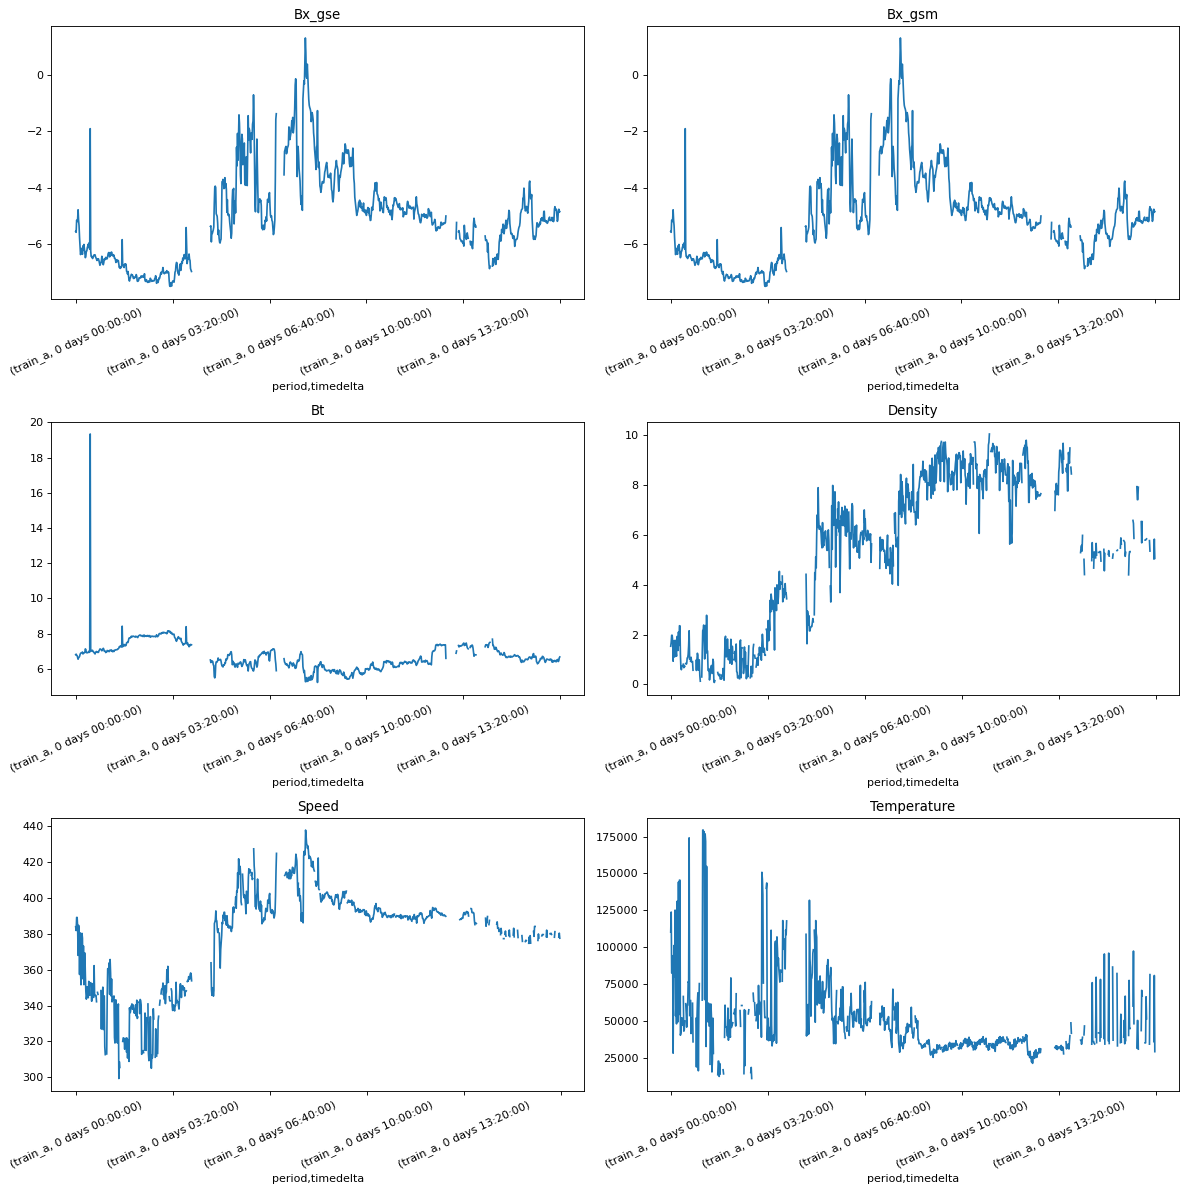

In [10]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [11]:
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

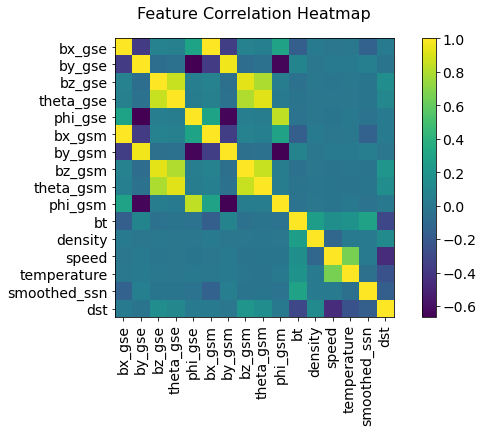

In [12]:
corr = solar_wind.join(sunspots).join(dst).fillna(method="ffill").corr()

plt.figure(figsize=(10, 5))
plt.matshow(corr, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

In [13]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

In [14]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [15]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [16]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [17]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [18]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val




In [19]:
train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

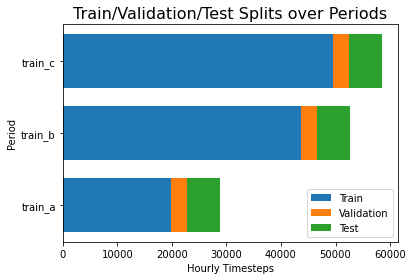

In [20]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

In [21]:
print(train.shape)
train.head()

(112872, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [22]:
print(test.shape)
test.head()

(18000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                          
train_a 951 days 00:00:00  -9 -9.0 -0.750759  0.234958         -0.321374   
        951 days 01:00:00  -9 -9.0 -0.791318  0.284752         -0.319784   
        951 days 02:00:00  -9 -6.0 -0.980331  0.573975         -0.257948   
        951 days 03:00:00  -6 -7.0 -1.043536 -0.412378         -0.209809   
        951 days 04:00:00  -7 -7.0 -0.993770 -0.603035         -0.189010   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 951 days 00:00:00        -0.263304     0.437479   -0.443221   
        951 days 01:00:00        -0.301259     0.321370    0.422124   
        951 days 02:00:00        -0.344924     0.530721    0.818555   
        951 days 03:00:00        -0.397676     0.753977   -0.432534   
        951 days 04:00:00        -0.402766     0.789420   -0.391195   

                           by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                             
train_a 951 days 00:00:00    -0.202748    0.318096     0.849393   -0.020478   
        951 days 01:00:00    -0.240443    0.166232     0.776471   -0.220270   
        951 days 02:00:00    -0.137579    0.157993     0.147218   -0.276363   
        951 days 03:00:00    -0.157578   -0.430909     0.121454   -0.282263   
        951 days 04:00:00    -0.252788   -0.372368    -0.149991   -0.510691   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 951 days 00:00:00   -0.145924  -0.503193     -0.407614    -0.315154   
        951 days 01:00:00   -0.127991  -0.084971     -0.427620    -0.198320   
        951 days 02:00:00   -0.120626  -0.310757     -0.435274    -0.374498   
        951 days 03:00:00   -0.180313  -0.531222     -0.414209    -0.365694   
        951 days 04:00:00   -0.219717  -0.649039     -0.437909    -0.267683   

                           smoothed_ssn  
period  timedelta                        
train_a 951 days 00:00:00      2.113449  
        951 days 01:00:00      2.113449  
        951 days 02:00:00      2.113449  
        951 days 03:00:00      2.113449  
        951 days 04:00:00      2.113449

In [23]:
print(val.shape)
val.head()

(9000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                          
train_a 826 days 00:00:00   9  8.0  0.947600 -0.229038         -0.473006   
        826 days 01:00:00   8  8.0  0.464361  0.276422          0.316358   
        826 days 02:00:00   8  9.0  0.273709  0.197794          0.073052   
        826 days 03:00:00   9  8.0  0.078250  0.445950          0.290167   
        826 days 04:00:00   8  8.0 -0.172001  0.071668          0.336941   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 826 days 00:00:00        -0.372466    -1.575773   -0.882804   
        826 days 01:00:00         0.379133    -1.614668   -0.280527   
        826 days 02:00:00         0.302776    -1.130185    0.809654   
        826 days 03:00:00         0.460514    -0.943295    1.891776   
        826 days 04:00:00         0.437184    -0.771915    0.408708   

                           by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                             
train_a 826 days 00:00:00     0.097349    1.132243     1.867509   -0.274071   
        826 days 01:00:00     0.397057    0.655653     0.530847    0.238450   
        826 days 02:00:00     0.320615    0.122597    -1.297872   -0.367564   
        826 days 03:00:00    -0.062777   -0.024515    -0.681155    1.253984   
        826 days 04:00:00     0.332551   -0.049795    -0.704262    1.021870   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 826 days 00:00:00   -0.323757  -0.527592      0.392352    -0.296261   
        826 days 01:00:00   -0.155733   0.142157      0.022523    -0.150077   
        826 days 02:00:00   -0.072557   0.563556     -0.200011    -0.089490   
        826 days 03:00:00   -0.001116   0.127350      0.135548     0.048349   
        826 days 04:00:00    0.063829   0.143625     -0.027986    -0.066235   

                           smoothed_ssn  
period  timedelta                        
train_a 826 days 00:00:00      2.191722  
        826 days 01:00:00      2.191722  
        826 days 02:00:00      2.191722  
        826 days 03:00:00      2.191722  
        826 days 04:00:00      2.191722

In [24]:
from keras import preprocessing


data_config = {
    "timesteps": 34,
    "batch_size": 34,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3315
Number of val batches: 261


In [25]:
from keras.layers import Dense, LSTM,Bidirectional
from keras.models import Sequential

# define our model
model_config = {"n_epochs": 15, "n_neurons": 256, "dropout": 0.1, "stateful": False}

# model = Sequential()
# model.add(
#     LSTM(
#         model_config["n_neurons"],
#         # usually set to (`batch_size`, `sequence_length`, `n_features`)
#         # setting the batch size to None allows for variable length batches
#         batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
#         stateful=model_config["stateful"],
#         dropout=model_config["dropout"],
#     )
# )
# model.add(Dense(len(YCOLS)))

model = Sequential()
model.add(Input(shape=(data_config["timesteps"],
                             len(XCOLS))))
model.add(Bidirectional(LSTM(model_config["n_neurons"],
                             batch_input_shape=(None, data_config["timesteps"],
                             len(XCOLS)),stateful=model_config["stateful"],
                             dropout=model_config["dropout"],return_sequences=True)))

model.add(Bidirectional(LSTM(125,
                             batch_input_shape=(None, data_config["timesteps"],
                             len(XCOLS)),stateful=model_config["stateful"],
                             dropout=model_config["dropout"],return_sequences=True)))
model.add(Bidirectional(LSTM(125, return_sequences=True, dropout=0.1)))
# model.add(Dense(512))
# model.add(Dense(256))
# model.add(Dense(125))
# model.add(Dense(50))
# model.add(Dense(len(YCOLS)))
# model.add(Dense(50))
# model.add(Dense(125))
# model.add(Dense(256))
# model.add(Dense(512))
# model.add(Dense(256))
# model.add(Dense(125))
# model.add(Dense(50))
model.add(Bidirectional(LSTM(125, return_sequences=False, dropout=0.1)))
model.add(Dense(8))
model.add(Dense(len(YCOLS)))


model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 34, 512)           557056    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 34, 250)           638000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 34, 250)           376000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 250)               376000    
_________________________________________________________________
dense (Dense)                (None, 8)                 2008      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 1,949,082
Trainable params: 1,949,082
Non-trainable params: 0
______________________________________________

In [26]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=-1,
    shuffle=False,
    validation_data=val_ds,
)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


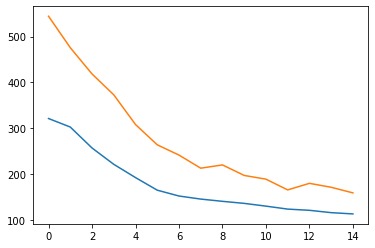

In [27]:
for name, values in history.history.items():
    plt.plot(values)

In [28]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])

In [29]:
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

525/525 [==============================] - 8s 15ms/step - loss: 163.6439
Test RMSE: 12.79


In [30]:
import json
import pickle

model.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

{'timesteps': 34, 'batch_size': 34, 'solar_wind_subset': ['bt', 'temperature', 'bx_gse', 'by_gse', 'bz_gse', 'speed', 'density']}


In [31]:
%%writefile predict.py

import json
import pickle
from typing import Tuple

import keras
import numpy as np
import pandas as pd

# Load in serialized model, config, and scaler
model = keras.models.load_model("model")

with open("config.json", "r") as f:
    CONFIG = json.load(f)

with open("scaler.pck", "rb") as f:
    scaler = pickle.load(f)

# Set global variables    
TIMESTEPS = CONFIG["timesteps"]
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


# Define functions for preprocessing
def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby([feature_df.index.floor("H")]).agg(aggs)

    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler


# THIS MUST BE DEFINED FOR YOUR SUBMISSION TO RUN
def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """
    Take all of the data up until time t-1, and then make predictions for
    times t and t+1.
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"] = latest_sunspot_number
    
    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1, TIMESTEPS, features.shape[1])
    )
    
    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1

Writing predict.py
